# Тестирование архитектур на собственных фото 80\20 с исползованием SGD и Adam

In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import torch
import torchvision
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from torchvision import transforms

from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier

torch.manual_seed(2)


# Предварительная загрузка и проверка данных

In [3]:
data_dir = 'semenov_dv_xv'
mtransforms = transforms.Compose([#torchvision.transforms.Grayscale(),
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])

                                 ])


train_data = torchvision.datasets.ImageFolder(data_dir + '/train/',  
                                    transform=mtransforms, )                                       
test_data = torchvision.datasets.ImageFolder(data_dir + '/test/', 
                                    transform=mtransforms)
#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'semenov_dv_xv/train/'

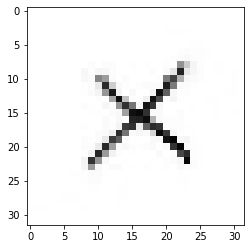

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
for i, (images, labels) in enumerate(testloader):
    imshow(torchvision.utils.make_grid(images))
    
    

# Описание всех используемых сетей

In [39]:
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(32*32, 1)
    def forward(self, x):
        x = self.fc1(x)
        return F.sigmoid(x)
    
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.log_softmax(x)
        return F.sigmoid(x)
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        #return F.log_softmax(x)
        return F.sigmoid(x)

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 1)
        self.bn1 = nn.BatchNorm1d(500)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(100)
    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.fc5(x)
        #return F.log_softmax(x)
        return F.sigmoid(x)
    
    
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, 5)
        self.fc1 = nn.Linear(3 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 3 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)

net = Net5()

In [8]:
print(net)

Net5(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=225, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


In [9]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [10]:
def train(epoches, step, net):
    accumul_acc = []
    accumul_loss = []
    test_acc =[]
    test_loss=[]
    LEARNING_RATE = 0.0003
    
    data_dir = 'semenov_dv_xv'
    mtransforms = transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(0.5,0.5)
                                     ])


    train_data = torchvision.datasets.ImageFolder(data_dir + '/train/',  
                                        transform=mtransforms, )                                       
    test_data = torchvision.datasets.ImageFolder(data_dir + '/test/', 
                                        transform=mtransforms)
    #Data Loading
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=1, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    #optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.5)
    
    for epoch in range(epoches):  # loop over the dataset multiple times
        epoch_loss = 0
        epoch_acc = 0
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader,0):

            # zero the parameter gradients
            optimizer.zero_grad()
            #print(inputs.shape)
            #plt.imshow(inputs[0][0], cmap='gray')
            #plt.pause(0.01)
            inputs = inputs.view(1, 32*32)
            #print(inputs.shape)
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            acc = binary_acc(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_loss += loss.item()
            #epoch_acc += acc.item()
            #accumul_acc.append(acc.item())
            accumul_loss.append(loss.item())
            

        
        cum_acc = 0
        cum_loss = 0
        for i, (inputs, labels) in enumerate(testloader,0):
            inputs = inputs.view(1, 32*32)
            outputs = net(inputs)
            tacc = binary_acc(outputs, labels.float().unsqueeze(1))
            tloss = criterion(outputs, labels.float().unsqueeze(1))
            cum_acc += tacc.item()
            cum_loss += tloss.item()
        test_acc.append(cum_acc/len(testloader))
        test_loss.append(cum_loss/len(testloader))
    

    print('Finished Training')
    return accumul_loss, test_acc, test_loss, net

In [55]:
%%time
loss1, tacc1, tloss1, net1 = train(30,1, Net1())

Finished Training
CPU times: user 9 s, sys: 313 ms, total: 9.31 s
Wall time: 9.33 s


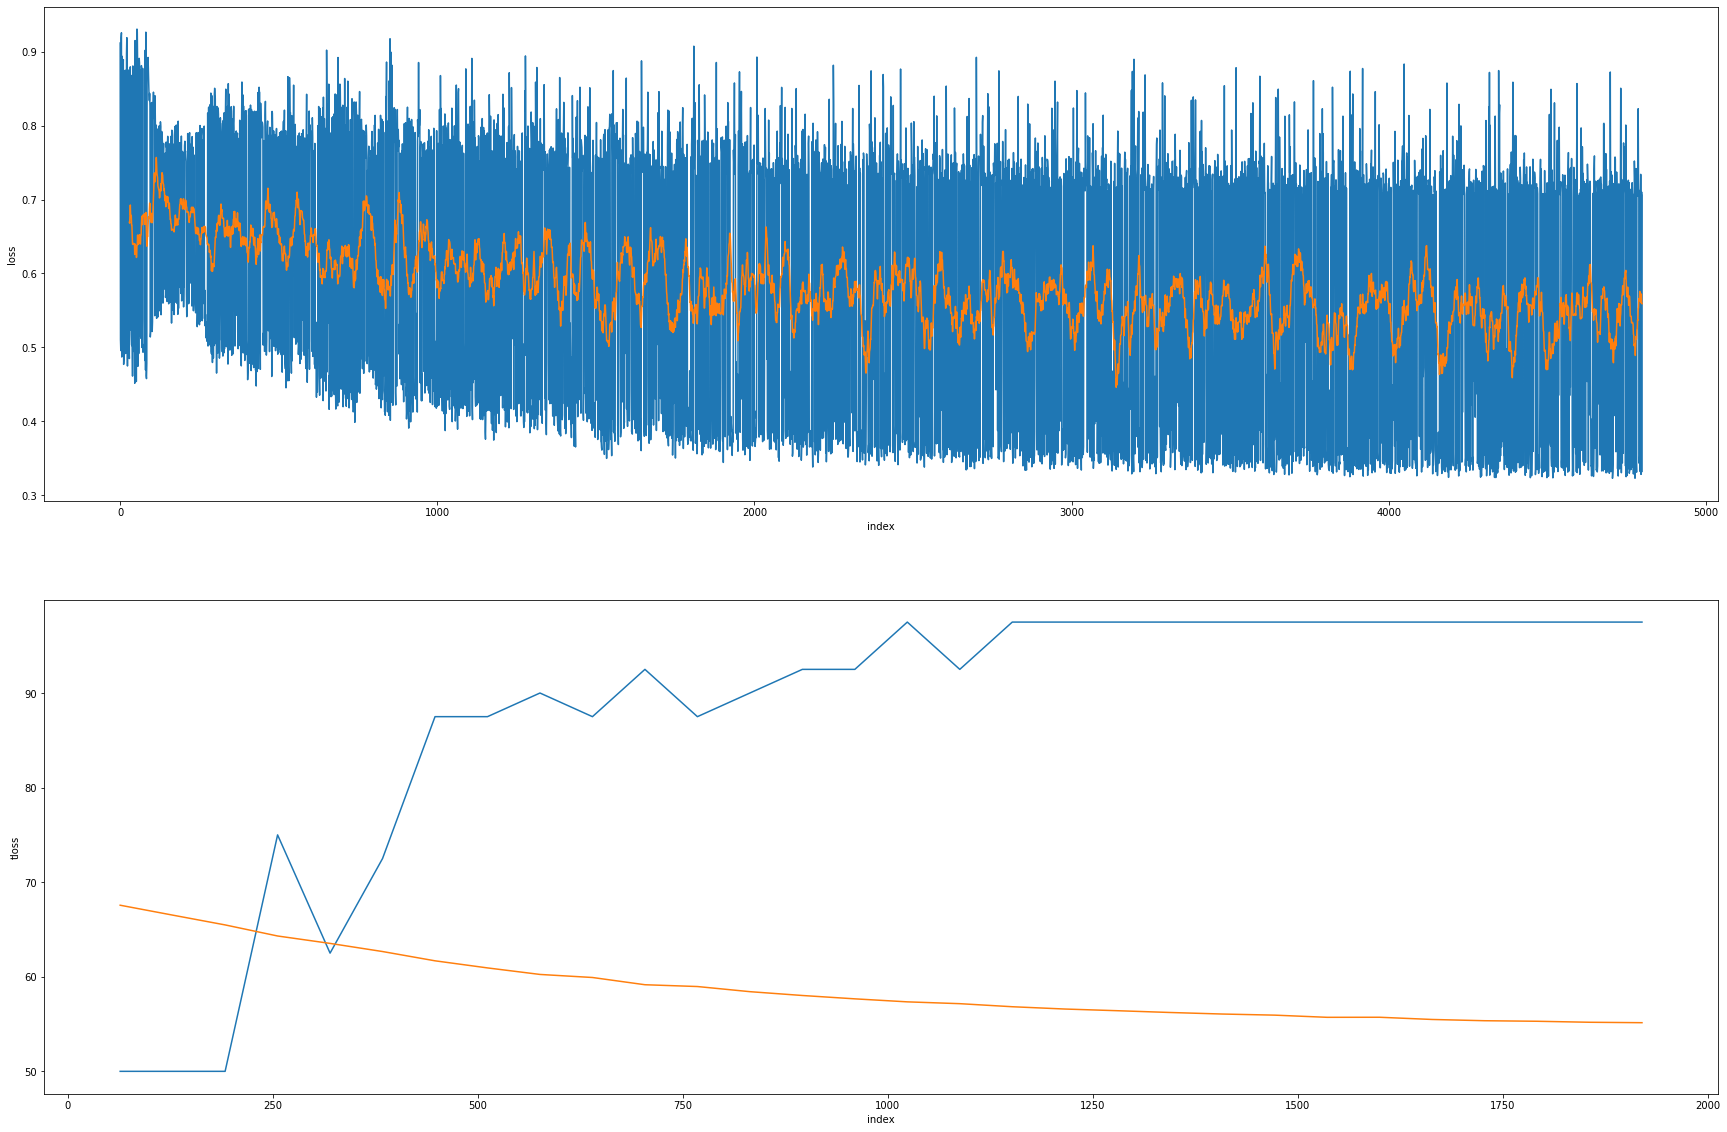

In [68]:
# train
df1 = pd.DataFrame(loss1, columns=['loss'])
df1['index'] = df1.index

# test
d1 = pd.DataFrame(tloss1, columns=['tloss'])
d1['tacc'] = tacc1
d1['index'] = (d1.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df1['index'], y=df1['loss'])
sns.lineplot(x=df1['index'], y=df1['loss'].rolling(30).mean().ffill())


# test acc and loss
plt.subplot(2,1,2)
sns.lineplot(x=d1['index'], y=d1['tacc'])
sns.lineplot(x=d1['index'], y=d1['tloss']*100)

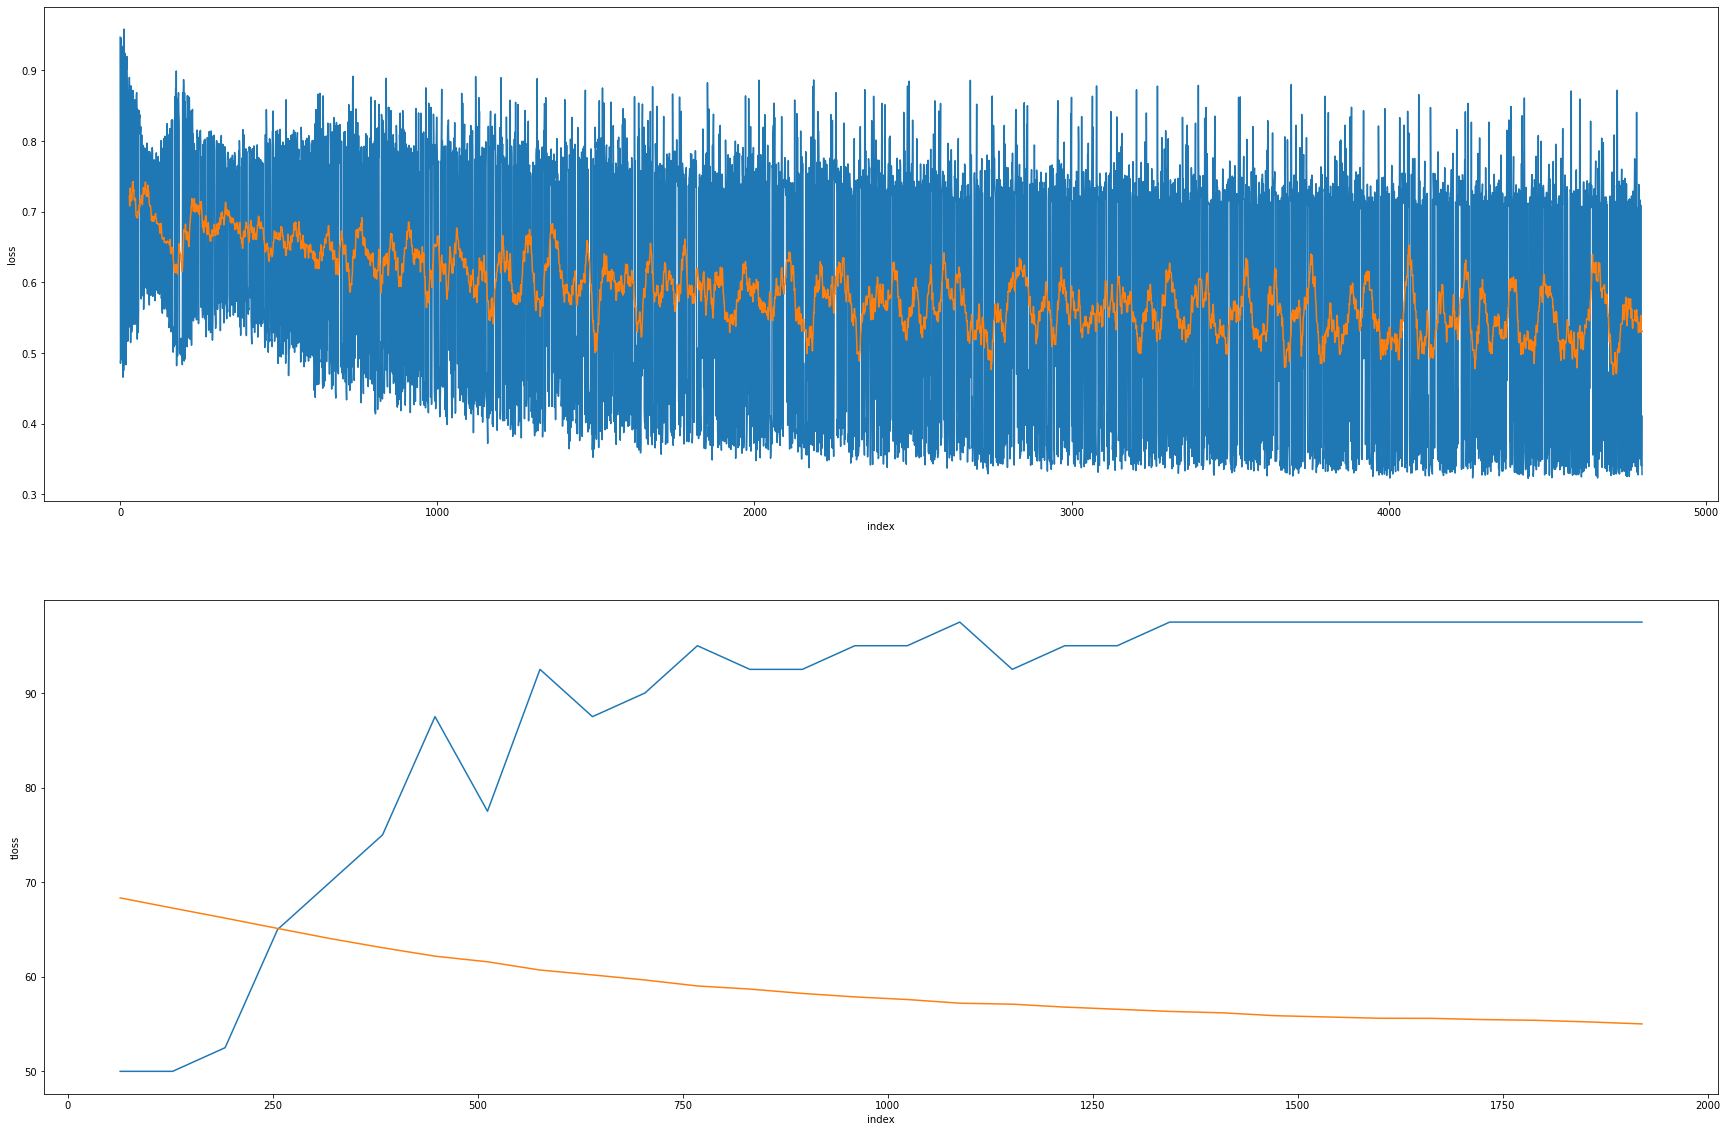

In [56]:
# train
df1 = pd.DataFrame(loss1, columns=['loss'])
df1['index'] = df1.index

# test
d1 = pd.DataFrame(tloss1, columns=['tloss'])
d1['tacc'] = tacc1
d1['index'] = (d1.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df1['index'], y=df1['loss'])
sns.lineplot(x=df1['index'], y=df1['loss'].rolling(30).mean().ffill())


# test acc and loss
plt.subplot(2,1,2)
sns.lineplot(x=d1['index'], y=d1['tacc'])
sns.lineplot(x=d1['index'], y=d1['tloss']*100)

In [57]:
%%time
loss2, tacc2, tloss2, net2 = train(100,1, Net2())

Finished Training
CPU times: user 3min 12s, sys: 1.99 s, total: 3min 14s
Wall time: 1min 11s


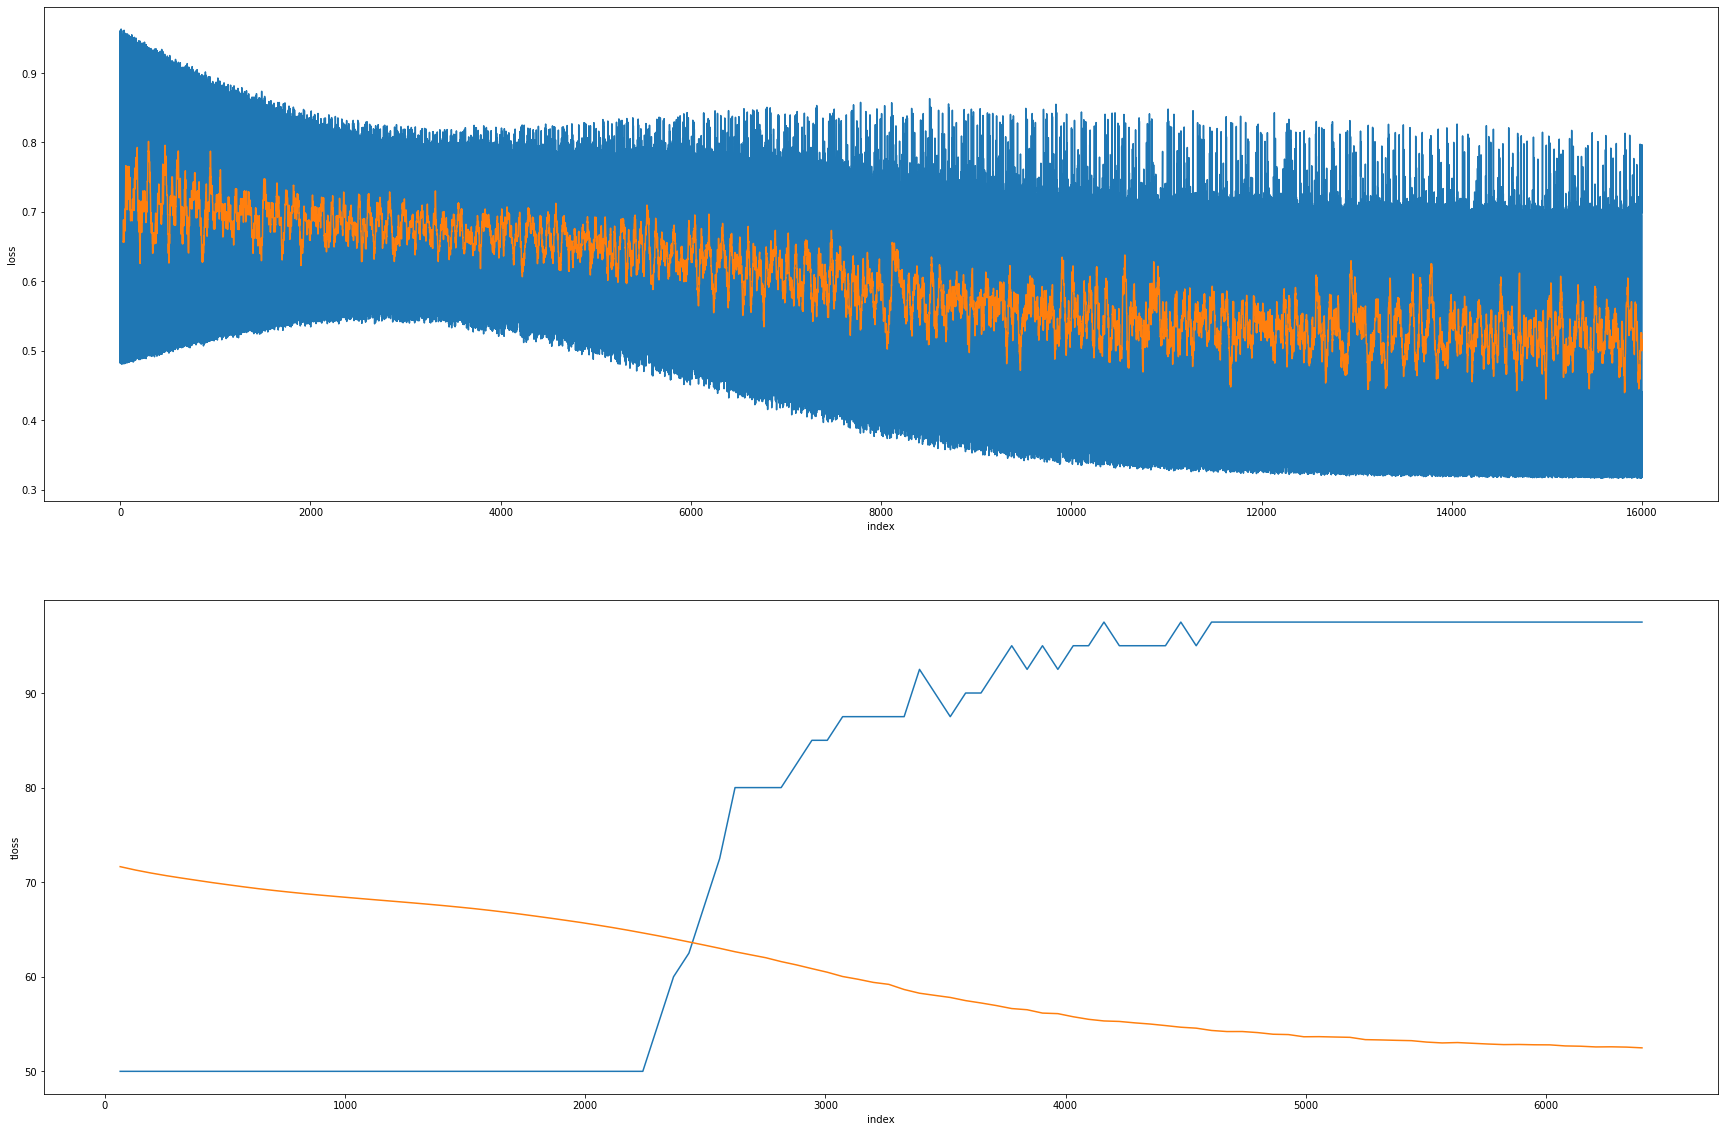

In [80]:
# train
df2 = pd.DataFrame(loss2, columns=['loss'])
df2['index'] = df2.index

# test
d2 = pd.DataFrame(tloss2, columns=['tloss'])
d2['tacc'] = tacc2
d2['index'] = (d2.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df2['index'], y=df2['loss'])
sns.lineplot(x=df2['index'], y=df2['loss'].rolling(30).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d2['index'], y=d2['tacc'])
sns.lineplot(x=d2['index'], y=d2['tloss']*100)

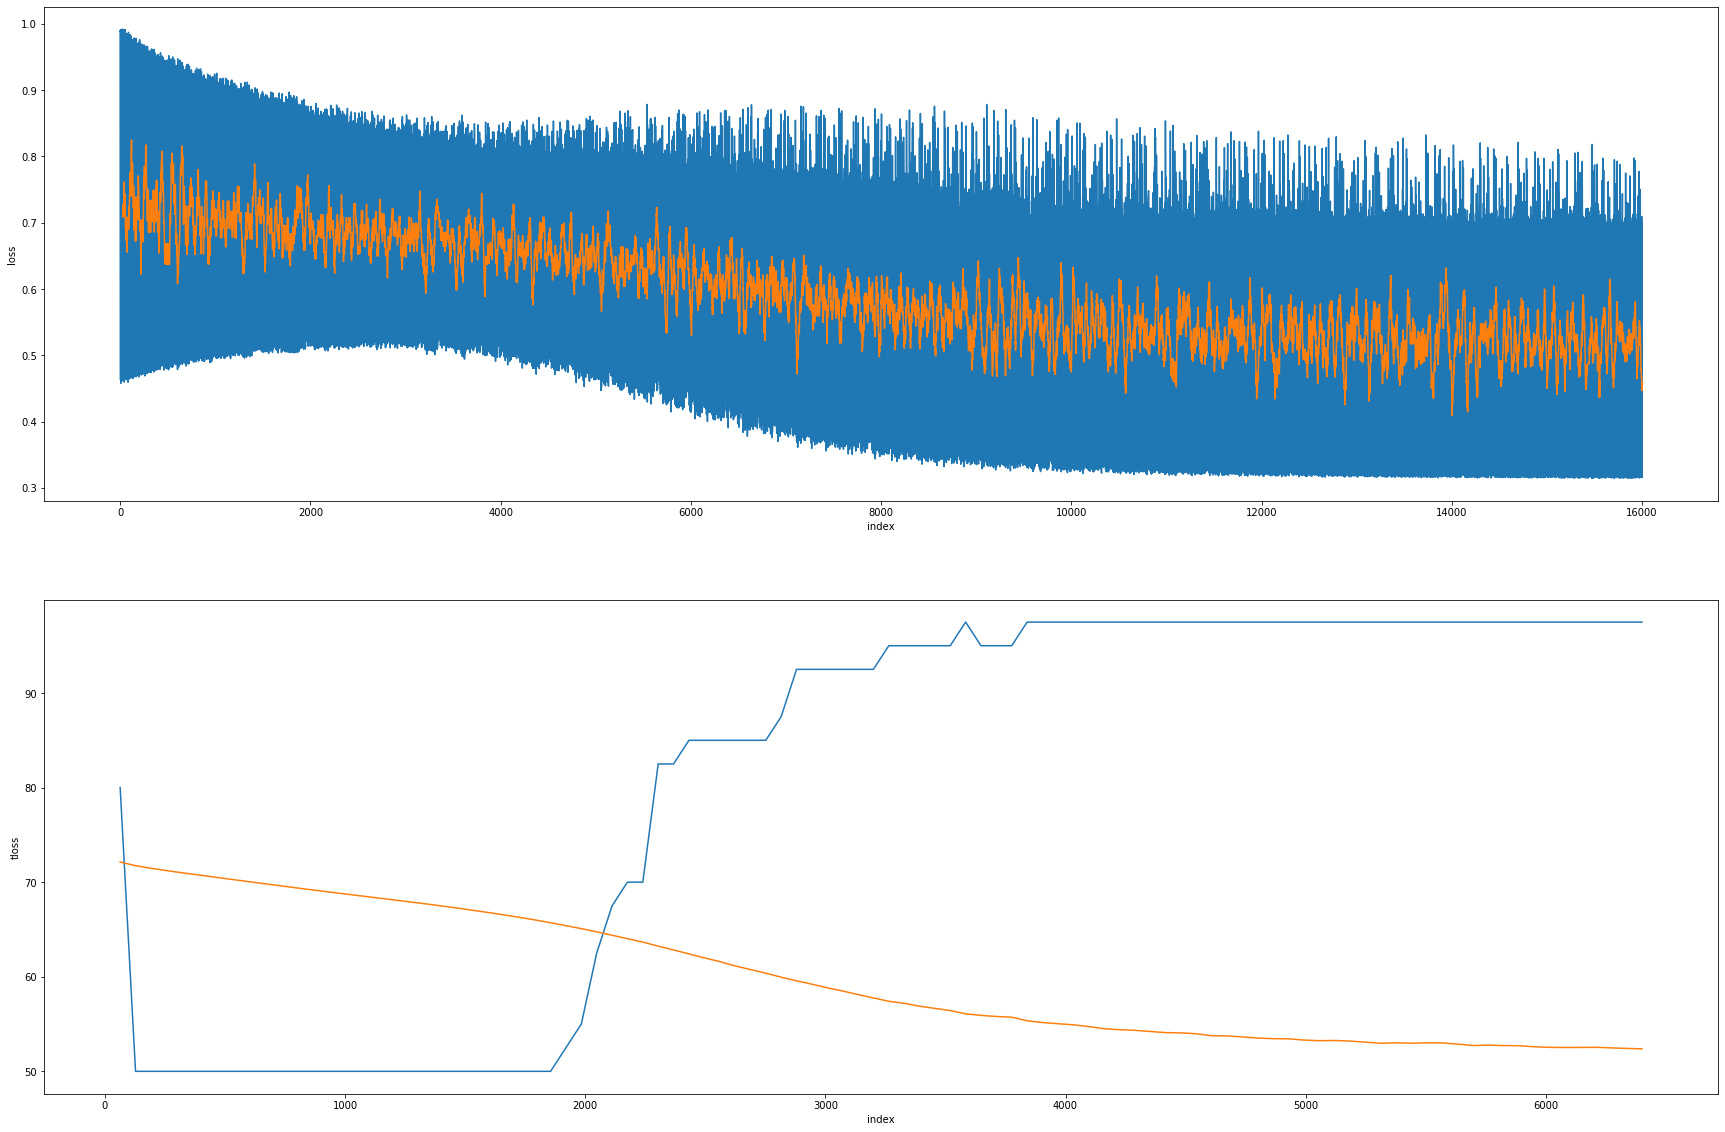

In [58]:
# train
df2 = pd.DataFrame(loss2, columns=['loss'])
df2['index'] = df2.index

# test
d2 = pd.DataFrame(tloss2, columns=['tloss'])
d2['tacc'] = tacc2
d2['index'] = (d2.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df2['index'], y=df2['loss'])
sns.lineplot(x=df2['index'], y=df2['loss'].rolling(30).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d2['index'], y=d2['tacc'])
sns.lineplot(x=d2['index'], y=d2['tloss']*100)

In [59]:
%%time
loss3, tacc3, tloss3, net3 = train(100,1, Net3())

Finished Training
CPU times: user 3min 12s, sys: 2.12 s, total: 3min 15s
Wall time: 1min 12s


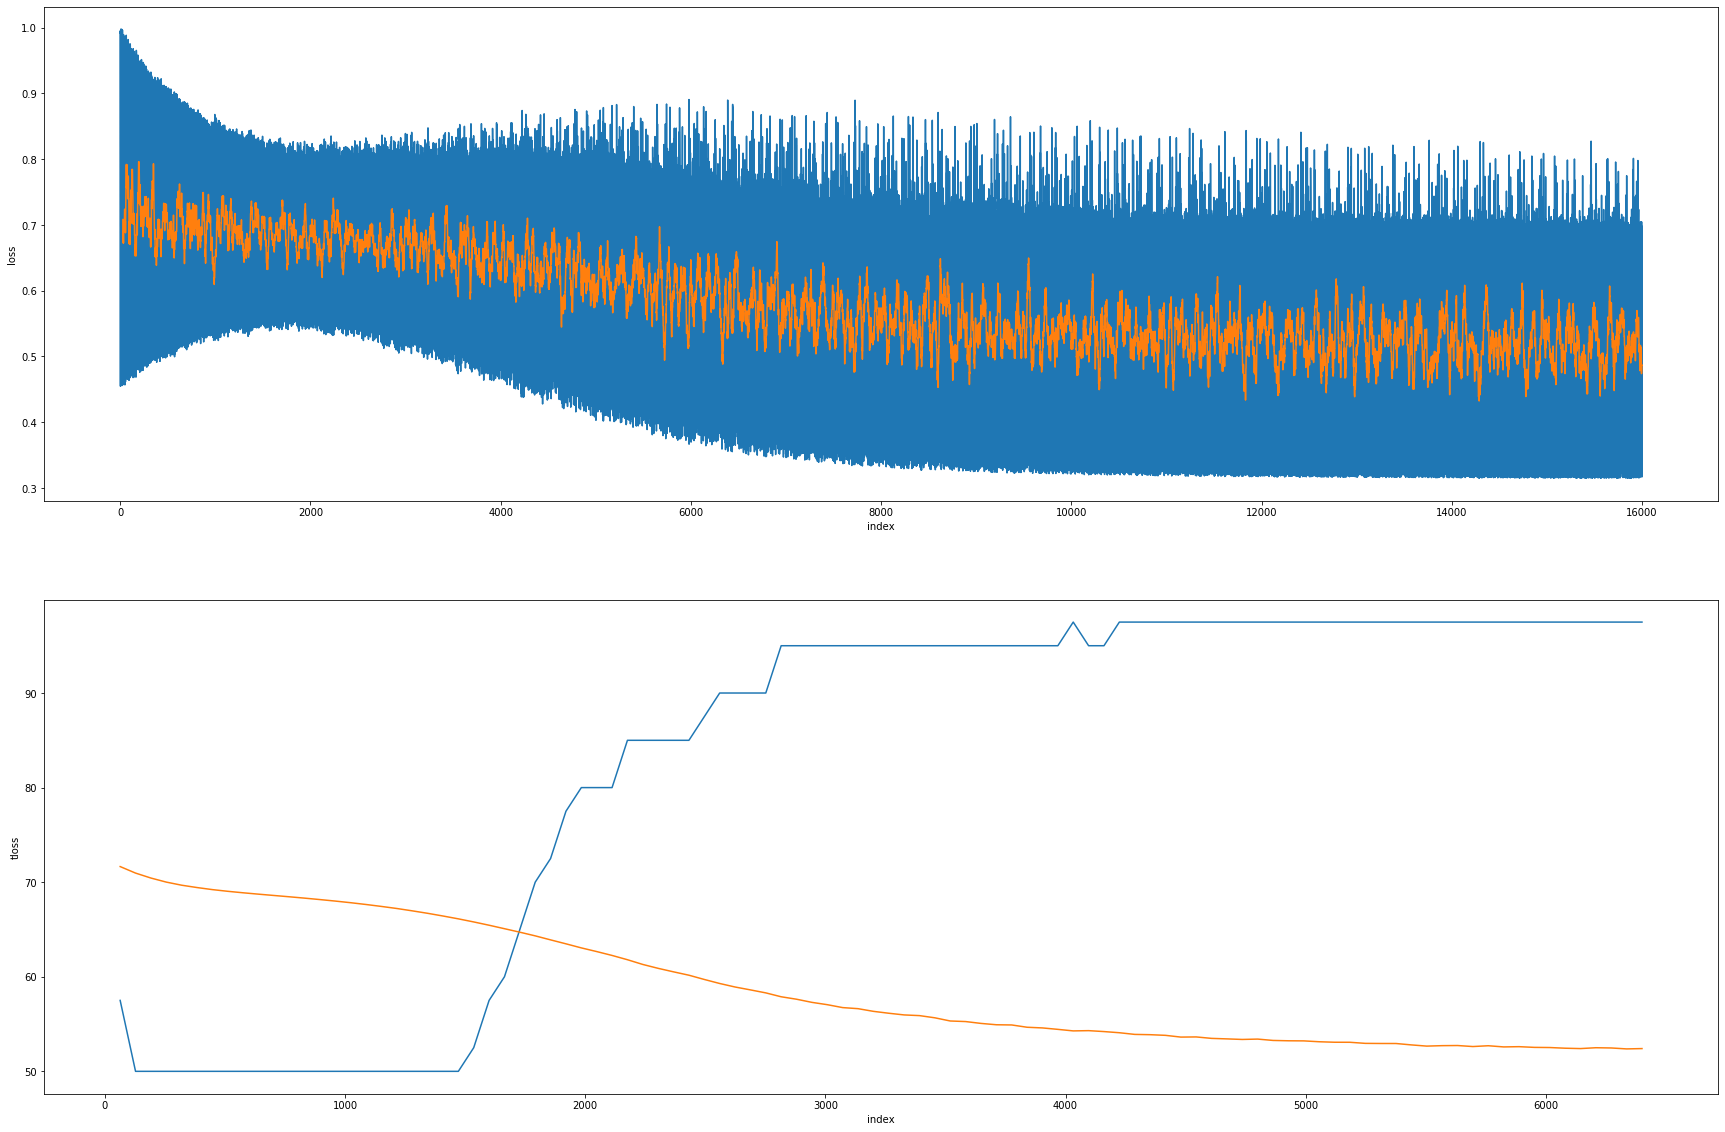

In [82]:
# train
df3 = pd.DataFrame(loss3, columns=['loss'])
df3['index'] = df3.index

# test
d3 = pd.DataFrame(tloss3, columns=['tloss'])
d3['tacc'] = tacc3
d3['index'] = (d3.index+1)*64

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df3['index'], y=df3['loss'])
sns.lineplot(x=df3['index'], y=df3['loss'].rolling(100).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d3['index'], y=d3['tacc'])
sns.lineplot(x=d3['index'], y=d3['tloss']*100)

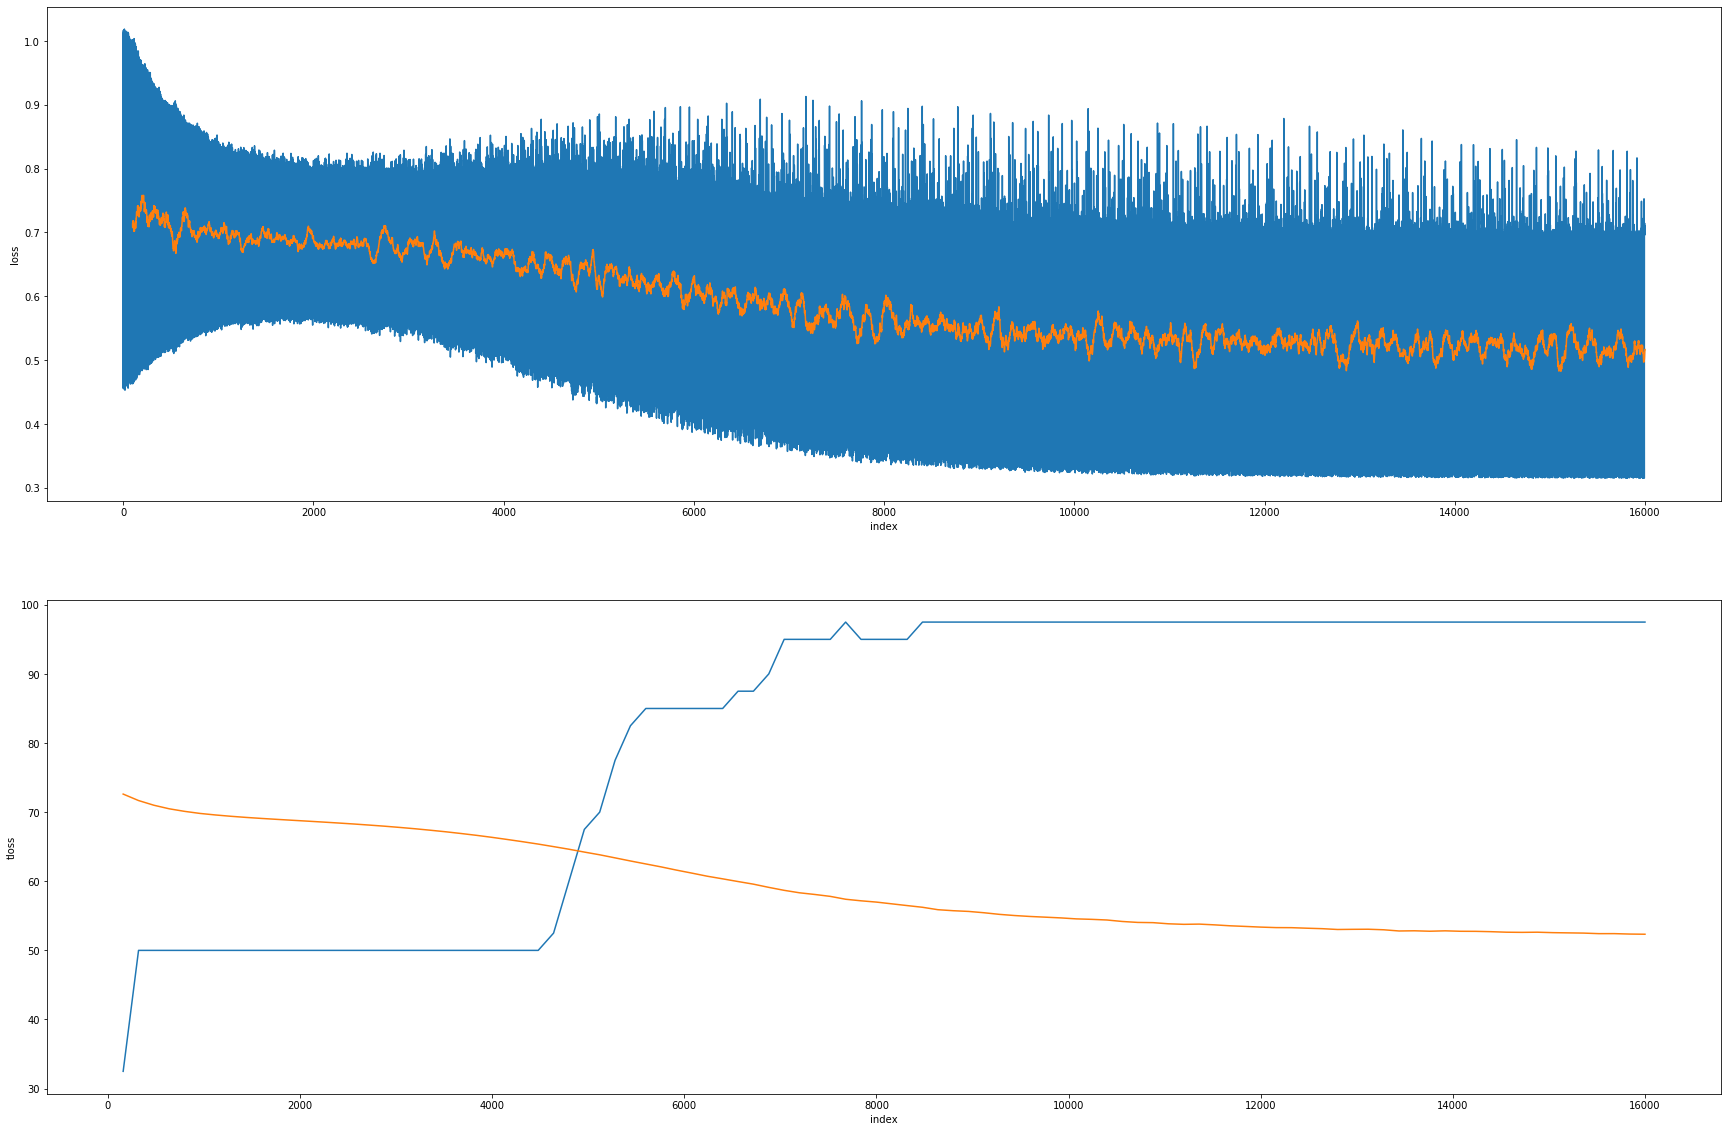

In [69]:
# train
df3 = pd.DataFrame(loss3, columns=['loss'])
df3['index'] = df3.index

# test
d3 = pd.DataFrame(tloss3, columns=['tloss'])
d3['tacc'] = tacc3
d3['index'] = (d3.index+1)*160

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df3['index'], y=df3['loss'])
sns.lineplot(x=df3['index'], y=df3['loss'].rolling(100).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d3['index'], y=d3['tacc'])
sns.lineplot(x=d3['index'], y=d3['tloss']*100)

In [44]:
def train5(epoches, step, net):
    accumul_acc = []
    accumul_loss = []
    test_acc =[]
    test_loss=[]
    LEARNING_RATE = 0.0003
    
    data_dir = 'semenov_dv_xv'
    mtransforms = transforms.Compose([#torchvision.transforms.Grayscale(num_output_channels=1),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(0.5,0.5)
                                     ])


    train_data = torchvision.datasets.ImageFolder(data_dir + '/train/',  
                                        transform=mtransforms, )                                       
    test_data = torchvision.datasets.ImageFolder(data_dir + '/test/', 
                                        transform=mtransforms)
    #Data Loading
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=1, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    #optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.5)
    
    for epoch in range(epoches):  # loop over the dataset multiple times
        epoch_loss = 0
        epoch_acc = 0
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader,0):

            # zero the parameter gradients
            optimizer.zero_grad()
            #print(inputs.shape)
            #plt.imshow(inputs[0][0], cmap='gray')
            #plt.pause(0.01)
            #inputs = inputs.view(1, 32*32)
            print(inputs.shape)
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            acc = binary_acc(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_loss += loss.item()
            #epoch_acc += acc.item()
            #accumul_acc.append(acc.item())
            accumul_loss.append(loss.item())
            

        
        cum_acc = 0
        cum_loss = 0
        for i, (inputs, labels) in enumerate(testloader,0):
            #inputs = inputs.view(1, 32*32)
            outputs = net(inputs)
            tacc = binary_acc(outputs, labels.float().unsqueeze(1))
            tloss = criterion(outputs, labels.float().unsqueeze(1))
            cum_acc += tacc.item()
            cum_loss += tloss.item()
        test_acc.append(cum_acc/len(testloader))
        test_loss.append(cum_los%%time
loss5, tacc5, tloss5, net5 = train5(5,1, Net5())s/len(testloader))
    

    print('Finished Training')
    return accumul_loss, test_acc, test_loss, net

In [53]:
%%time
loss5, tacc5, tloss5, net5 = train5(5,1, Net5())

Finished Training
CPU times: user 13.2 s, sys: 205 ms, total: 13.4 s
Wall time: 5.79 s


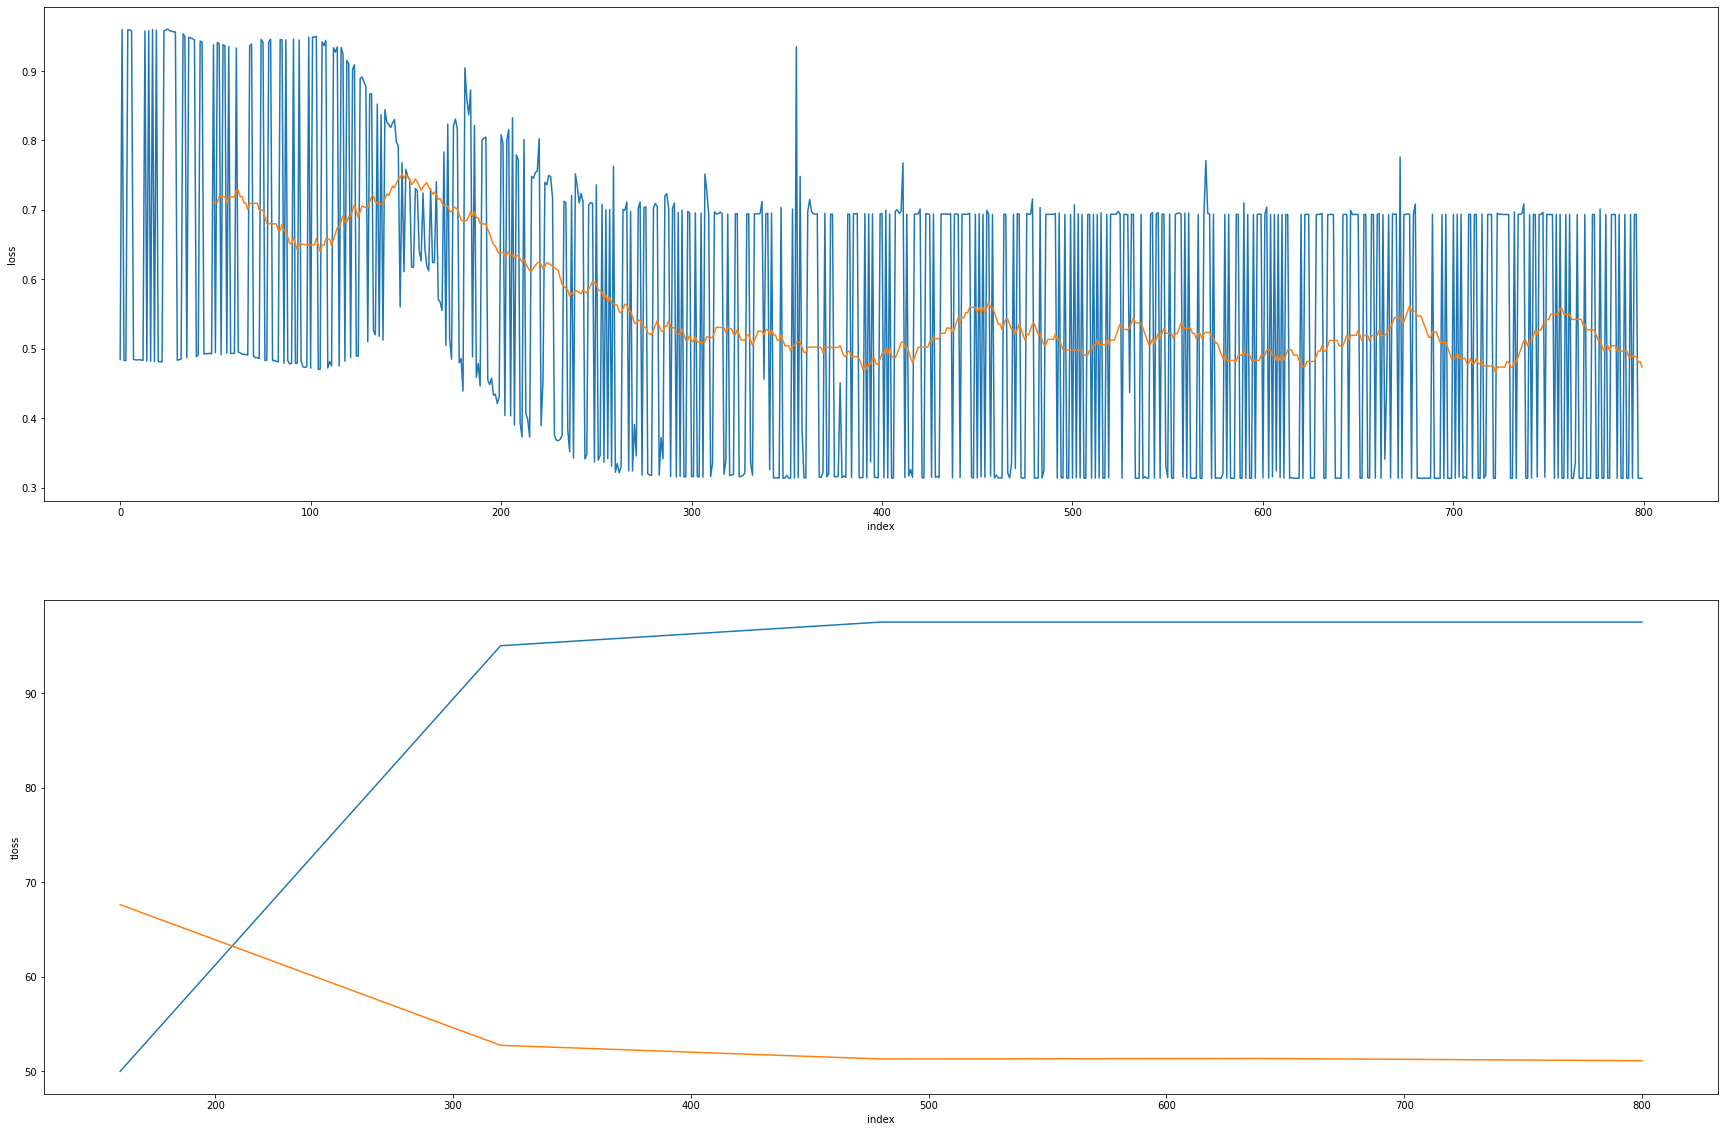

In [67]:
# train
df5 = pd.DataFrame(loss5, columns=['loss'])
df5['index'] = df5.index

# test
d5 = pd.DataFrame(tloss5, columns=['tloss'])
d5['tacc'] = tacc5
d5['index'] = (d5.index+1)*160

fig = plt.figure(figsize=(30,20))
plt.subplot(2,1,1)

# train loss
sns.lineplot(x=df5['index'], y=df5['loss'])
sns.lineplot(x=df5['index'], y=df5['loss'].rolling(50).mean().ffill())



plt.subplot(2,1,2)
sns.lineplot(x=d5['index'], y=d5['tacc'])
sns.lineplot(x=d5['index'], y=d5['tloss']*100)

In [1]:
%%time
lo, ta, tl, n = train5(5,1, Net5())

NameError: name 'train5' is not defined